In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
from keras.preprocessing import image



In [25]:
dataset = './dataset/images/'
imageLabels = './dataset/imageLabels.txt'


In [50]:
categories = [
    "Pepperoni",
    "Bacon",
    "Mushrooms",
    "Onions",
    "Peppers",
    "Black olives",
    "Tomatoes",
    "Spinach",
    "Fresh basil",
    "Arugula",
    "Broccoli",
    "Corn",
    "Pineapple"
]

In [47]:
with open(imageLabels, 'r') as file:
    lines = file.readlines()
    y = []
    for line in lines:
        class_array = [int(num) for num in line.split()]
        y.append(class_array)
        
    y= np.array(y)    
        

print(y)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [56]:
y.shape

(9213, 13)

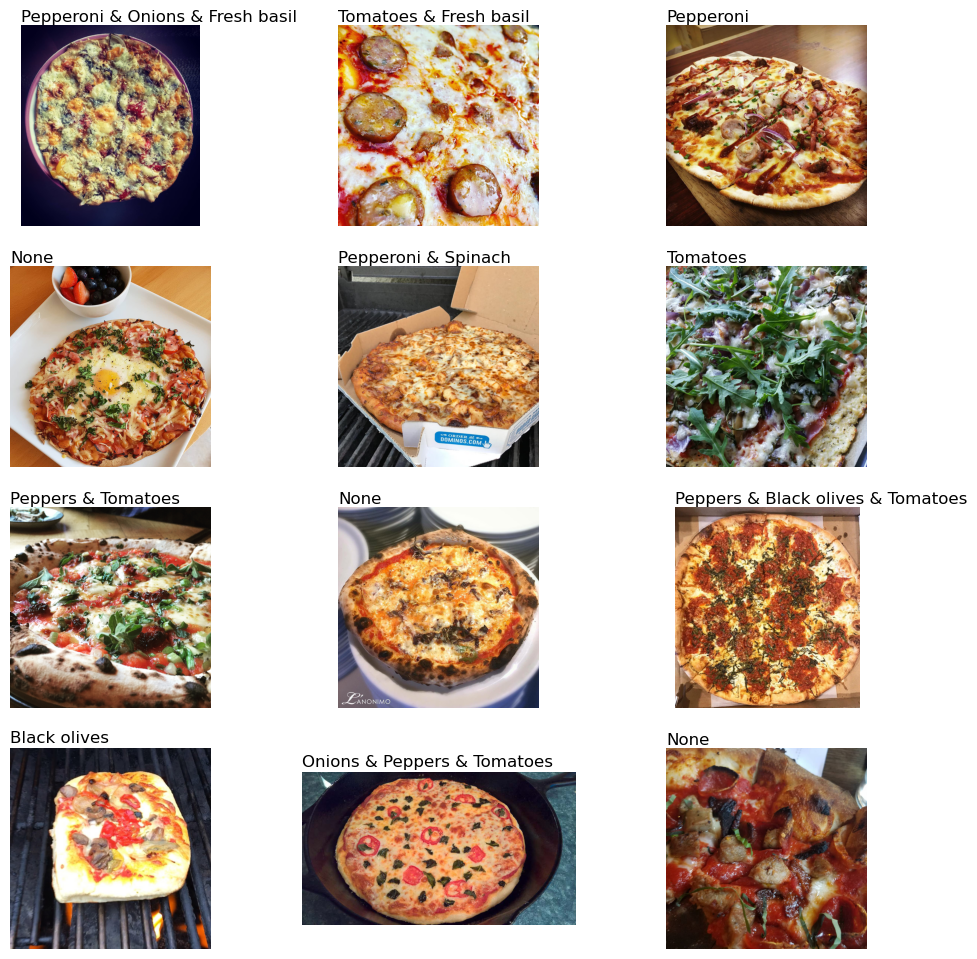

In [61]:
def plot_images():
    
    plt.figure(figsize=(12, 12))
    indexes = [random.randint(0, 9213) for _ in range(12)]
    for i, index in enumerate(indexes):
        j= '{:05d}'.format(index)
        img_path = dataset+"/"+str(j)+'.jpg'
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img)/255.0
        
        cat = []
        for k, label in enumerate(y[index]):
            if label == 1: 
                cat.append(categories[k])
                
                
        # Join categories into a single string
        if cat ==[]:
            cat_str = 'None'
        else :
            cat_str = ' & '.join(cat)        
        
        # Create Subplot and plot the images
        plt.subplot(4, 3, i+1)
        plt.imshow(img_arr)
        plt.axis('off')
        plt.text(0, -20, cat_str, fontsize=12, ha='left')
        
    plt.show()

        
plot_images()        
        
       

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])